In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

In [30]:
bars = pd.read_csv("hour6.csv")
prices = bars.pivot(index="CloseTime", columns = "Symbol", values="Close")
prices.index = pd.to_datetime(prices.index)
prices = prices.last("30D")

In [78]:
def fitKCA(t,z,q,fwd=0):    
    '''
    Inputs:
        t: Iterable with time indices
        z: Iterable with measurements
        q: Scalar that multiplies the seed states covariance
        fwd: number of steps to forecast (optional, default=0)
    Output:
        x[0]: smoothed state means of position velocity and acceleration
        x[1]: smoothed state covar of position velocity and acceleration
    Dependencies: numpy, pykalman
    '''
    #1) Set up matrices A,H and a seed for Q
    h=(t[-1]-t[0])/t.shape[0]
    A=np.array([[1,h,.5*h**2],
                [0,1,h],
                [0,0,1]])
    Q=q*np.eye(A.shape[0])
    #2) Apply the filter    
    kf=KalmanFilter(transition_matrices=A,transition_covariance=Q)
    #3) EM estimates
    kf=kf.em(z)
    #4) Smooth
    x_mean,x_covar=kf.filter(z)
    #5) Forecast
    for fwd_ in range(fwd):
        x_mean_,x_covar_=kf.filter_update(filtered_state_mean=x_mean[-1], \
            filtered_state_covariance=x_covar[-1])
        x_mean=np.append(x_mean,x_mean_.reshape(1,-1),axis=0)
        x_covar_=np.expand_dims(x_covar_,axis=0)
        x_covar=np.append(x_covar,x_covar_,axis=0)
    #6) Std series
    x_std=(x_covar[:,0,0]**.5).reshape(-1,1)
    for i in range(1,x_covar.shape[1]):
        x_std_=x_covar[:,i,i]**.5
        x_std=np.append(x_std,x_std_.reshape(-1,1),axis=1)
    return x_mean,x_std,x_covar

In [79]:
z = np.log(prices.BTCUSDT).values
t = np.linspace(0, z.shape[0])
q = 1.0
mean, std, covar = fitKCA(t, z, q)

<AxesSubplot:xlabel='CloseTime'>

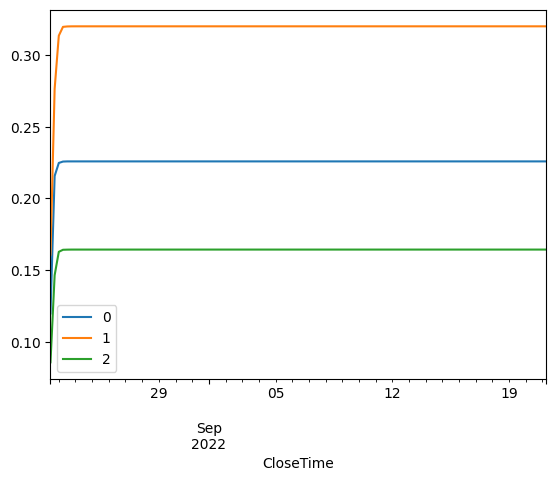

In [80]:
pd.DataFrame(std, index=prices.index).plot()

<AxesSubplot:xlabel='CloseTime'>

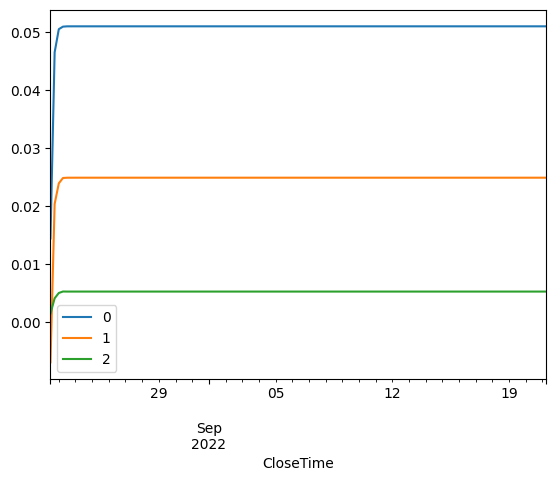

In [81]:
pd.DataFrame(covar[:,0], index=prices.index).plot()

In [84]:
kca = pd.DataFrame(mean, index=prices.index, columns = ["P", "V", "A"]).join(prices.BTCUSDT).iloc[10:]
#kca = kca.sub(kca.mean(axis=0)).div(kca.std(axis=0))

<AxesSubplot:xlabel='CloseTime'>

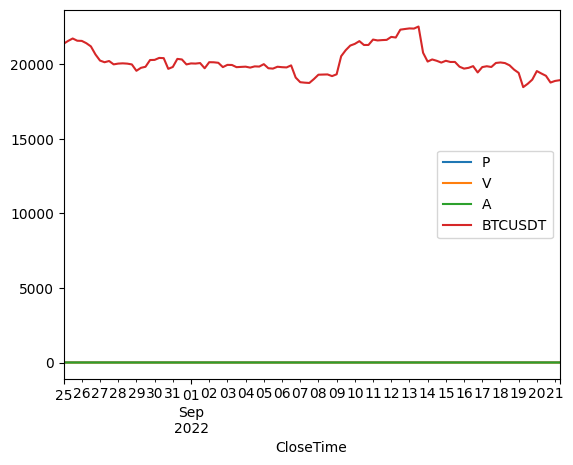

In [85]:
kca.plot()

<AxesSubplot:xlabel='CloseTime'>

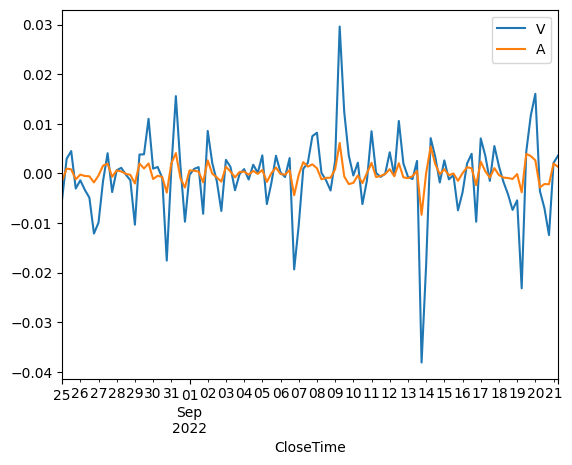

In [86]:
kca[["V", "A"]].plot()

<AxesSubplot:xlabel='CloseTime'>

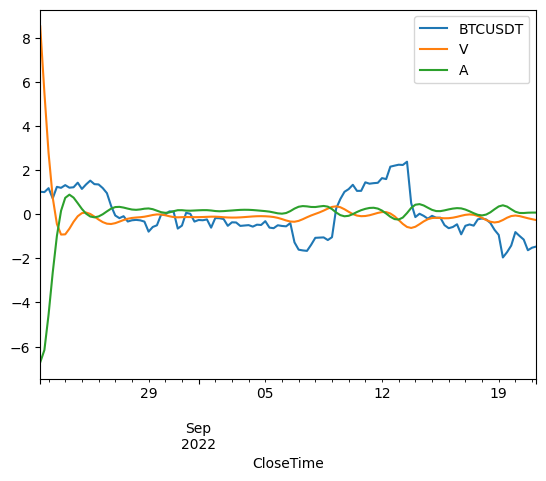

In [41]:
kca[["BTCUSDT", "V", "A"]].plot()

In [42]:
kca.C.plot()

AttributeError: 'DataFrame' object has no attribute 'C'